<a href="https://colab.research.google.com/github/aahFancyGun/dataScienceClass/blob/master/unit7/YangChau_Unit7Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font face="times" size=100px color='blue' font-style='bold'> Unit 7 Project: Predicting Nuclear Energy Trends <font>


In [23]:
!pip install "preliz[full,notebook]"
!pip install bambi

In [24]:
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import arviz as az
import seaborn as sns
import pymc as pm
from scipy.interpolate import PchipInterpolator
import bambi as bmb

#Introduction

## The "Big" Goal

My goal in doing this project is to predict the net generation of nuclear energy using a variety of different models, variables

### Sub-objectives

- analyzing the results to gain a better understanding on the trends of nuclear energy and how its growing, shrinking, or stagnating.
- expanding those observed trends to a wider societal view and try to understand how this data might indicate how the public might view nuclear energy.

I'd also like to evaluate how each of these types of models will perform against one another by analyzing them through both numerical means (elpd_loo) and through real-world analysis (how well they predict actual reality)

## Context

Nuclear energy generation is one of the most cutting edge forms of energy generation currently in humanity's arsenal and can be seen as something of a middle ground between renewable non-renewable energy resources.
  - While nuclear energy generation does produce waste, the majority of this waste is harmless and the rest is easily and safely stored.
    - non-renewable wastes are instead unsafely stored in the air we breathe
  - In general, much more favorable ratio of energy generated per square foot taken up than all known renewables
  - Fuel can be recycled into more energy creating a sort of quasi renewable energy source

Personally, I have always had a fascination and love for nuclear energy in spite of disasters like chernobyl and fukushima. It is my personal belief that in general, they are misrepresented and wrongfully feared because of such incidents while argubaly much more damaging forms of energy including some renewables do not suffer from such a negative stigma being attached to them.

# Data Wrangling

## Specificities

The number one thing you need to know about this data is that I'm cutting out around a third of it and starting at 265th row. The reason I did this is simply because before this row, not all columns had defined data, and at certain instances, a few columns simply had "undefined" in a cell.

- As for nitty gritty stuff, this dataset covers several important elements in tracking Nuclear power generation which I will list out briefly below

  - Nuclear Generating Units, Total Operable Units: The total number of operable nuclear generating units (data is only 100% available starting at row 265).

  - Nuclear Generating Units, Net Summer Capacity: The net summer capacity of nuclear generating units in million kilowatts.

  - Nuclear Electricity Net Generation: The net generation of electricity from nuclear power in millions of kilowatt-hours.

  - Nuclear Share of Electricity Net Generation: The percentage share of total electricity net generation coming from nuclear power.

  - Nuclear Generating Units, Capacity Factor: The capacity factor (actual output vs potential output) of nuclear generating units.

### Sourcing

This dataset was sourced from a kaggle dataset that was formed from various reputable sources like the U.S. Energy Information Administration (EIA), the World Resources Institute, the Ember Climate, the U.S. Nuclear Regulatory Commission (NRC), and Our World in Data.

In [25]:
url = "https://raw.githubusercontent.com/aahFancyGun/dataScienceClass/master/unit7/nuclear_energy_overview_eia.csv"

data = pd.read_csv(url)[264:] #reading data

data #printing data

,Year,Month,Nuclear_Generating_Units_Total__Operable_Units,Nuclear_Generating_Units_Net_Summer_Capacity,Nuclear_Electricity_Net_Generation,Nuclear_Share_of_Electricity_Net_Generation,Nuclear_Generating_Units_Capacity_Factor
264,1995,January,109,99.148,63342,22.6,85.9
265,1995,February,109,99.148,51858,20.6,77.8
266,1995,March,109,99.148,51880,19.9,70.3
267,1995,April,109,99.148,49321,20.2,69.2
268,1995,May,109,99.148,54387,20.6,73.7
...,...,...,...,...,...,...,...
609,2023,October,93,95.746,61403,18.6,86.2
610,2023,November,93,95.746,62258,19.3,90.3
611,2023,December,93,95.746,68898,19.9,96.7
612,2024,January,93,95.723,69080,18.2,97.1


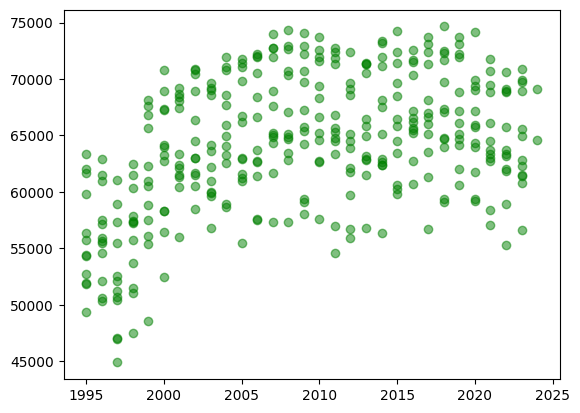

In [26]:
# Plot predictions
plt.scatter(data["Year"], data["Nuclear_Electricity_Net_Generation"], color='green', alpha=0.5)
plt.show()

## Initial Analysis

At first glance it certainly seems I've arrived at a dead end of sorts in terms of usable data as it can be observed that the overall trend seems to be a blob. However, further analysis reveals that it is very likely that these overlapping points on each of the years represent the different months within that year; which I believe will have differing energy generation influenced by the season. For example, during hotter or colder months I expect energy generated to be higher due to an increased energy demand from appliances like heating and AC. Thus, you can extend such conclusions to say that this data does not represent one trend but rather twelve different trends each correlating with one month of the year.

Also, note the fact that the overall trend appears logarithmic in nature, which suggests stagnation of nuclear development in the last few decades. In fact, despite the fact that overall energy requirements in America have risen by around ~30%, the grown of nuclear energy generation has only increased by ~10%. This statistic, coupled with the fact that the number of nuclear reactors in America have actually decreased over the last 30 years reveals that stagnation begins may be the only answer to the second objective I posed in this project.

#Generating Models
For this project, I'll be using two main overarching types of models: B-spline, polynomial, linear, and logarithmic
- b-splines are eseentially piecewise functions

- polynomial models represent data along the curve of a given polynomial, for example a degree two model would try to get a parabola to fit the data

- similar to polynomial models, a logarithmic model will attempt to fit data along the curve of its parent functio (a logarithm)

- Linear will attempt to find a line of best fit for the data


## Creating Model Formulae

## Variables

My main variables for most of these models is going to be month and year as they have the most direct causal relationship between the net nuclear energy generation at a given time.
- That said, I will be experimenting with adding on additional variables
- nuclear generating units
  - as direct if not more so than year and month
- Nuclear Generating Units, Capacity Factor
  - Calculated by dividing actual output by potential output for a given time and multiplying by 100
    - may be able to indicate months of higher generation as the nuclear plant may have to operate for longer

## Linear Formulae

In [27]:
#Linear formula 1 (month and year)
linear_formula_1 = "Nuclear_Electricity_Net_Generation ~ Year + Month"
linear_model_1 = bmb.Model(linear_formula_1, data)
idata_linear_1 = linear_model_1.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


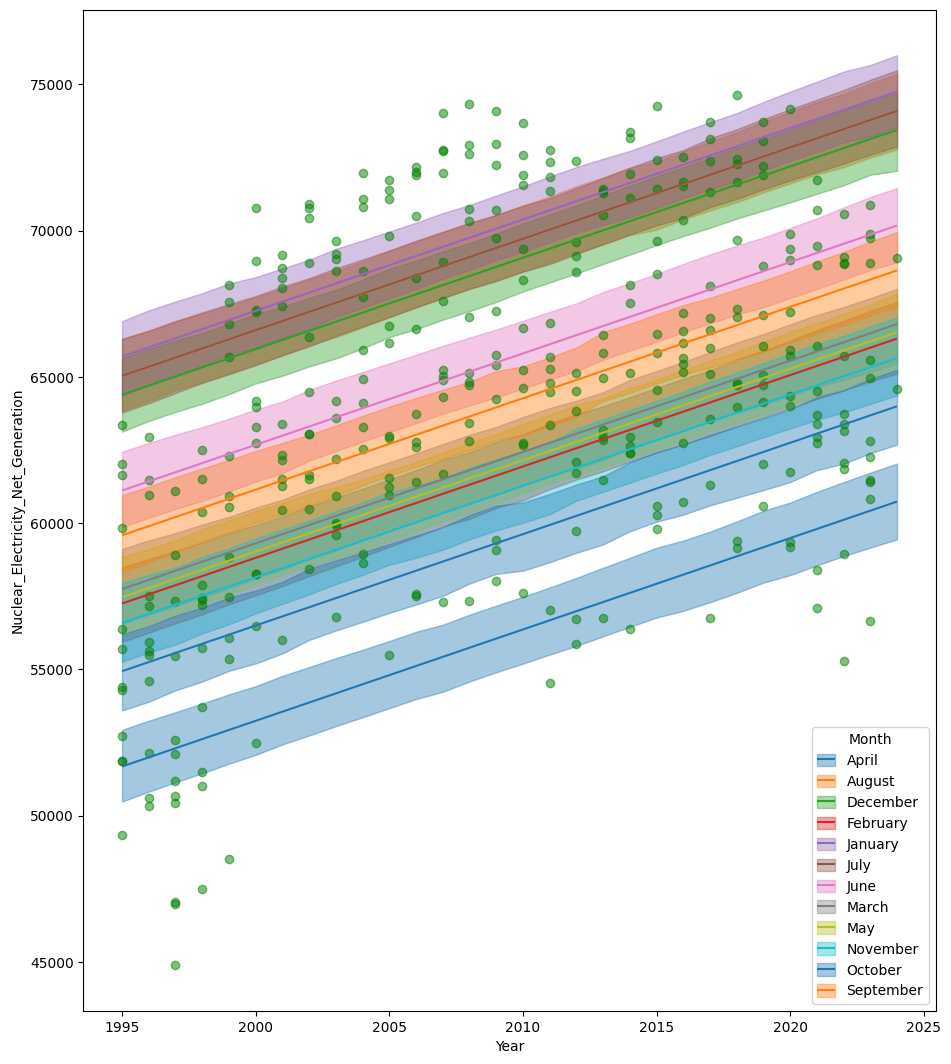

In [28]:
bmb.interpret.plot_predictions(linear_model_1,
                               idata_linear_1,
                               ["Year", "Month"],
                               fig_kwargs={"figsize":(11, 13)})

plt.scatter(data["Year"], data["Nuclear_Electricity_Net_Generation"], color='green', alpha=0.5)


## Logarithmic Formulae

In [29]:
#log formula 1 (month and year)
log_formula_1 = "Nuclear_Electricity_Net_Generation ~ log10(Year) + Month"
log_model_1 = bmb.Model(log_formula_1, data)
idata_log_1 = log_model_1.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


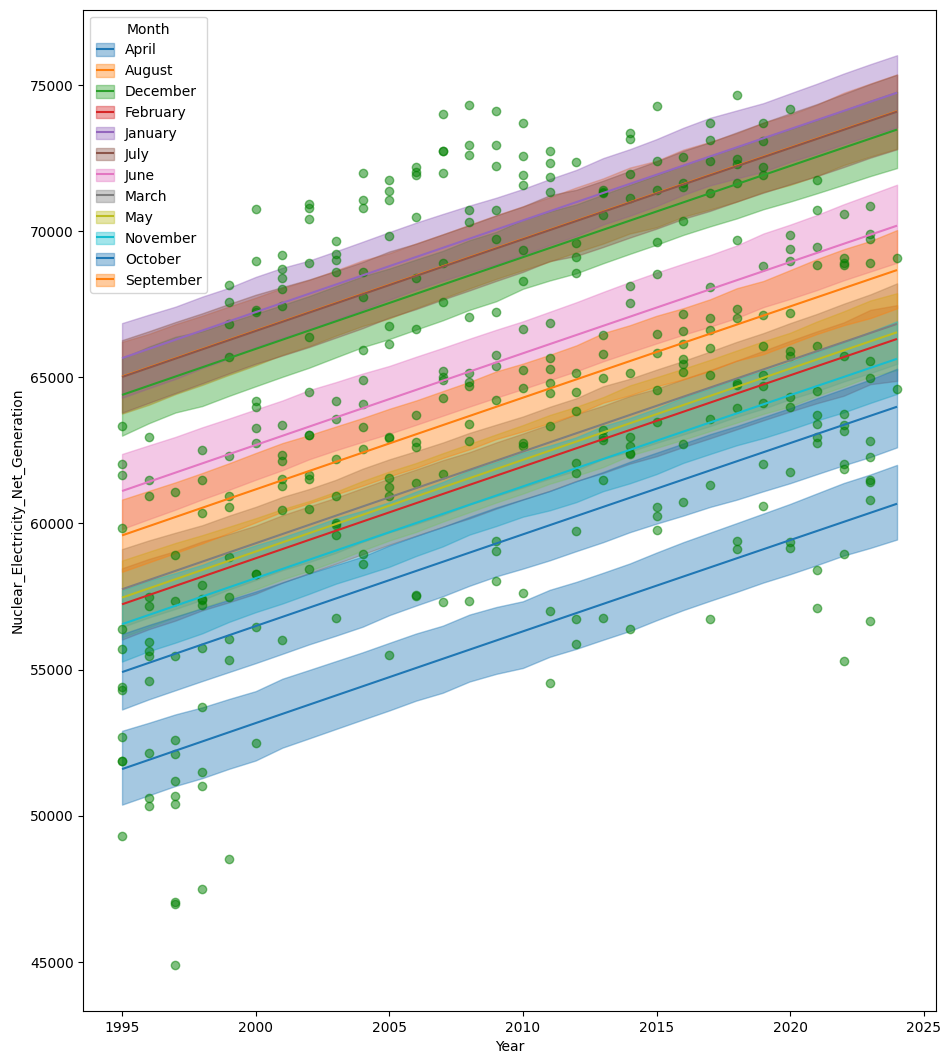

In [30]:
bmb.interpret.plot_predictions(log_model_1,
                               idata_log_1,
                               ["Year", "Month"],
                               fig_kwargs={"figsize":(11, 13)})

plt.scatter(data["Year"], data["Nuclear_Electricity_Net_Generation"], color='green', alpha=0.5)


## Polynomial Formulae

In [31]:
#Poly Formula 1 (month and year)
poly_formula_1 = "Nuclear_Electricity_Net_Generation ~ poly(Year, degree=7) + Month"
poly_model_1 = bmb.Model(poly_formula_1, data)
idata_poly_1 = poly_model_1.fit(idata_kwargs={'log_likelihood': True})

Output()

In [32]:
#Poly Formula 2 (Month, Year, and Nuclear Generating Units)
poly_formula_2 = "Nuclear_Electricity_Net_Generation ~ poly(Year, degree=7) + Month + Nuclear_Generating_Units_Total__Operable_Units"
poly_model_2 = bmb.Model(poly_formula_2, data)
idata_poly_2 = poly_model_2.fit(idata_kwargs={'log_likelihood': True})

Output()

In [33]:
#Poly Formula 3 (Month, Year, and Nuclear Generating Units, Capacity Factor)
poly_formula_3 = "Nuclear_Electricity_Net_Generation ~ poly(Year, degree=7) + Month + Nuclear_Generating_Units_Capacity_Factor"
poly_model_3 = bmb.Model(poly_formula_3, data)
idata_poly_3 = poly_model_3.fit(idata_kwargs={'log_likelihood': True})

Output()

In [34]:
#Poly Formula 4 (Month, Year, Nuclear Generating Units, Capacity Factor, and Nuclear Generating Units)
poly_formula_4 = "Nuclear_Electricity_Net_Generation ~ poly(Year, degree=7) + Month + Nuclear_Generating_Units_Capacity_Factor + Nuclear_Generating_Units_Total__Operable_Units"
poly_model_4 = bmb.Model(poly_formula_4, data)
idata_poly_4 = poly_model_4.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


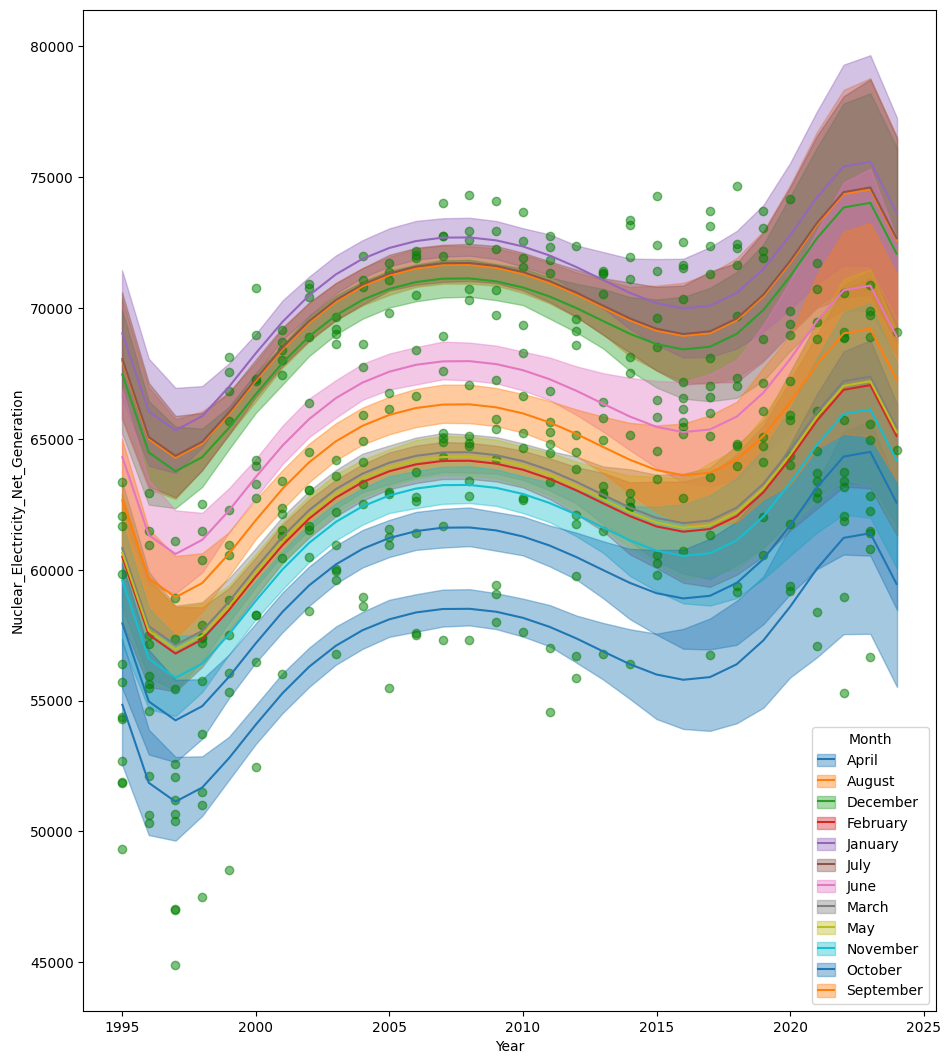

In [35]:
bmb.interpret.plot_predictions(poly_model_2,
                               idata_poly_2,
                               ["Year", "Month"],
                               fig_kwargs={"figsize":(11, 13)})

plt.scatter(data["Year"], data["Nuclear_Electricity_Net_Generation"], color='green', alpha=0.5)



### Poly-Analysis 1
After looking at how all the models fit against our data, it seems like model 2 is best, which looks total nuclear generating units, the month, and the year. So, just for fun, I've decided to take that one step further and introduce month instead in a hierarchical relationship with the other variables

Also, one thing I'd like to add is that even though I'm not showing the graphs of models that have nuclear generating capacity in them, when I did look at them, they fit absolutely horridly. I think that this is because I am trying to predict an overall trend across several years whereas nuclear generating capacity would probably work best in predicting energy generation across different months in a single year as energy demand fluctuates with the season.

Another thing to add is that every single polynomial graph curves down at the end as a result of being well, polynomial, and thus being required to generally follow the path of a polynomial function. In representing the real world and specifically predicting energy output though, this is very very bad. There is no real world scenario where nuclear energy output will suddenly take a nose down at the rate these models suggest.

In [36]:
#Bonus Polynomial Formula (Year and Nuclear Generating Units with month in hierarchical relationship)
poly_formula_5 = "Nuclear_Electricity_Net_Generation ~ poly(Year, degree=7) +  Nuclear_Generating_Units_Total__Operable_Units + (1 | 'Month')"
poly_model_5 = bmb.Model(poly_formula_5, data)
idata_poly_5 = poly_model_5.fit(idata_kwargs={'log_likelihood': True})

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


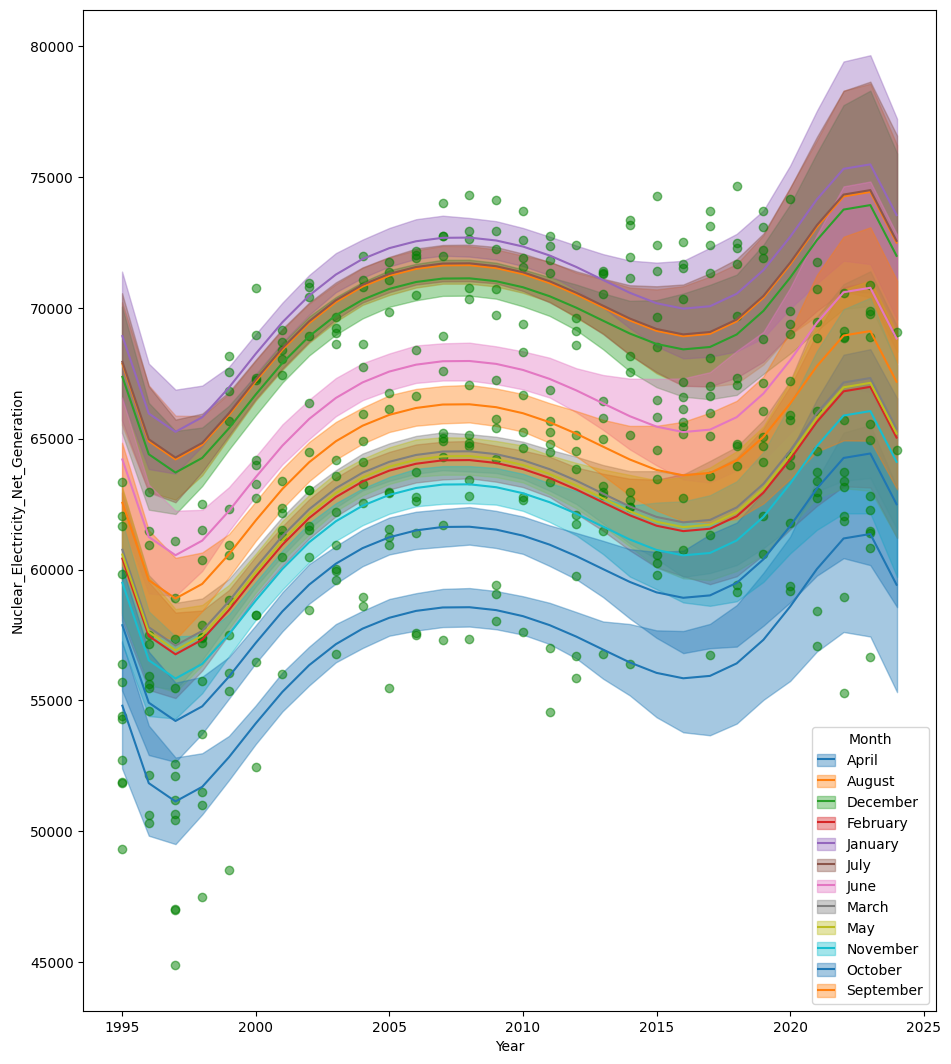

In [37]:
bmb.interpret.plot_predictions(poly_model_5,
                               idata_poly_5,
                               ["Year", "Month"],
                               fig_kwargs={"figsize":(11, 13)})

plt.scatter(data["Year"], data["Nuclear_Electricity_Net_Generation"], color='green', alpha=0.5)




### Poly-Analysis 2
They largely seem the same and the hierarchical model had a divergence so we'll just call poly model 2 the winner for now and move on to a new type of model.

## B-Spline Formulae

Note that I will not be including nuclear energy unit capacity factor in these models for reasons outined in poly-analysis 1.


In [38]:
#b-spline Formula 1 (month and year)
b_spline_formula_1 = "Nuclear_Electricity_Net_Generation ~ bs(Year, df=5) + Month"
b_spline_model_1 = bmb.Model(b_spline_formula_1, data)
idata_spline_1 = b_spline_model_1.fit(idata_kwargs={'log_likelihood': True})

Output()

In [39]:
#b-spline Formula 2 (month, year, and nuclear generating units)
b_spline_formula_2 = "Nuclear_Electricity_Net_Generation ~ bs(Year, df=5) + Month + Nuclear_Generating_Units_Total__Operable_Units"
b_spline_model_2 = bmb.Model(b_spline_formula_1, data)
idata_spline_2 = b_spline_model_2.fit(idata_kwargs={'log_likelihood': True})

Output()

In [40]:
#b-spline Formula 3 (year and nuclear generating units with month in a hierarchical relationship)
b_spline_formula_3 = "Nuclear_Electricity_Net_Generation ~ bs(Year, df=5) + Nuclear_Generating_Units_Total__Operable_Units + (1 | 'Month')"
b_spline_model_3 = bmb.Model(b_spline_formula_3, data)
idata_spline_3 = b_spline_model_3.fit(idata_kwargs={'log_likelihood': True})

Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


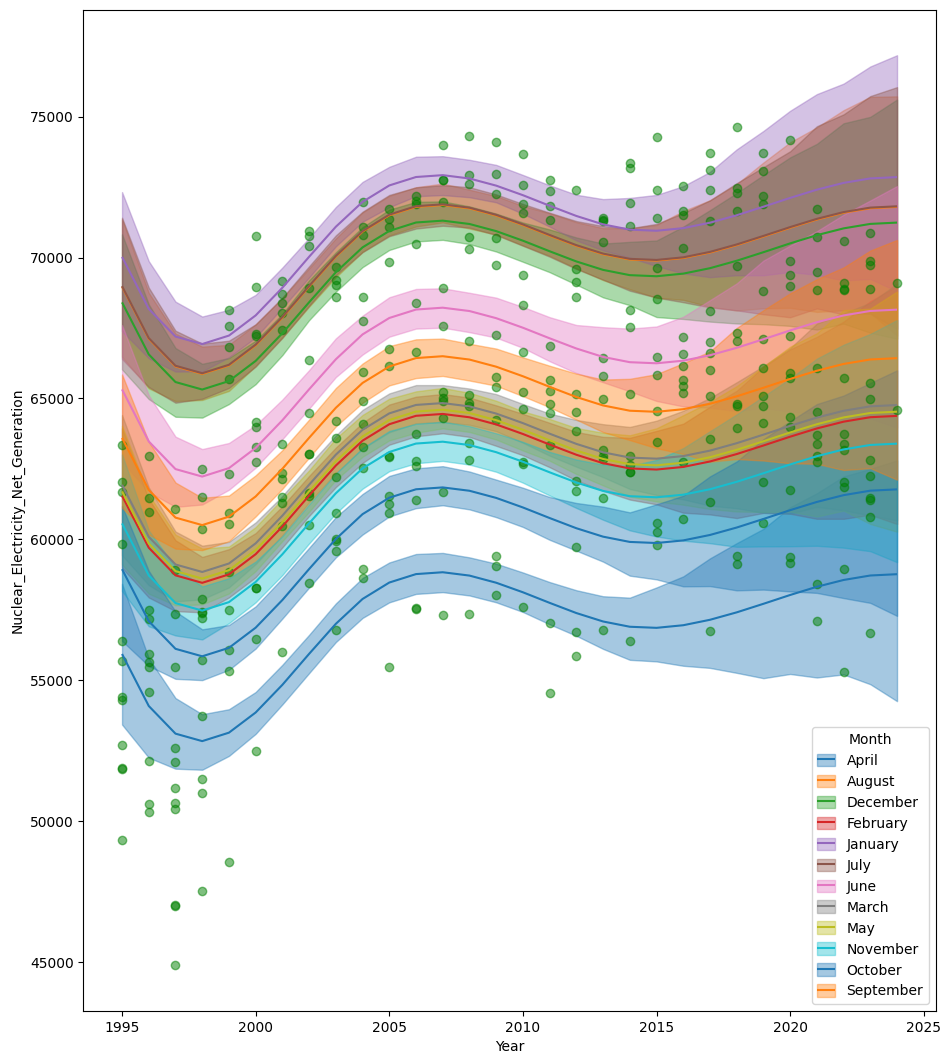

In [41]:
bmb.interpret.plot_predictions(b_spline_model_3,
                               idata_spline_3,
                               ["Year", "Month"],
                               fig_kwargs={"figsize":(11, 13)})

plt.scatter(data["Year"], data["Nuclear_Electricity_Net_Generation"], color='green', alpha=0.5)

### B-spline Analysis
Immediately one of the first things that pops out at me when I look at my third model for b-spline is that across all models, this is the only one that maintains a feasible trend even after it has no more points to predict. In my eyes, even before we do any analysis with elpd_loo that in conjunction with the fact that it fits so well, makes this model the most true to reality.

That said, on the left-hand side of the model, it aggressively tapers up which certainly isn't realistic either. I am willing to tolerate this though, as I'm more interested in the model being able to predict a feasible future than for a model to accurately model past energy trends.

# Numerical and Qualitative Comparisons

## Numerical (elpd_loo)

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

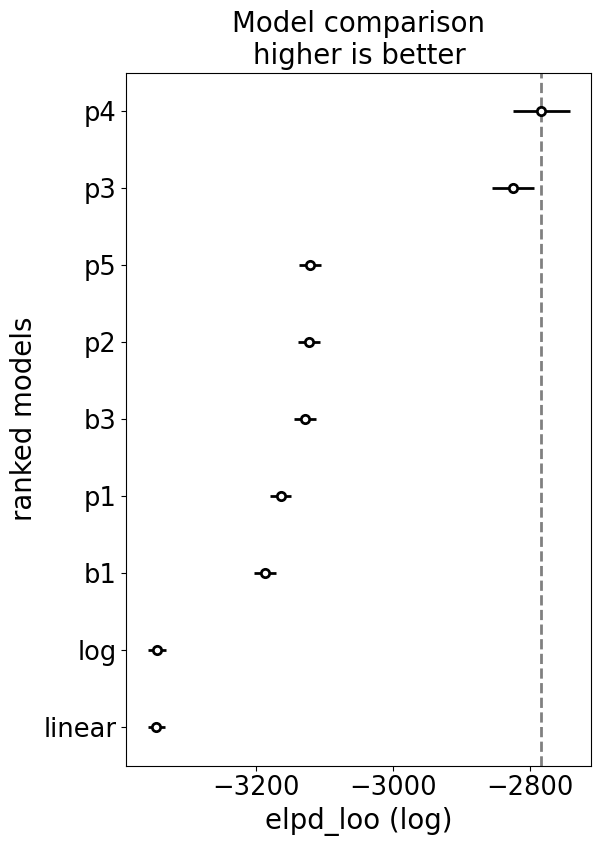

In [42]:
cmp = az.compare({"p1":idata_poly_1,"p2":idata_poly_2, "p3":idata_poly_3, "p4":idata_poly_4, "p5":idata_poly_5, "b1":idata_spline_1, "b1":idata_spline_2, "b3":idata_spline_3, "linear": idata_linear_1, "log": idata_log_1})
az.plot_compare(cmp)


### Elpd_loo comparisons Analysis

This is, to say the least, extremely unexpected for me. My analysis for both my b-spline and polynomial functions firmly put models p2 and p5 ahead of p4 and p3, which underperformed considerably in terms of matching data. Even more surprising though is the fact that b3, which I believe to be the most true to reality, is ranked even further below those two. I really don't have the slightest idea as to why its behaving like this but I think this really does highlight the importance of not just relying on tools like elpd_loo when creating models. It's equally important that we take the time to analyze and evaluate our models based on our objectives.

Additionally, despite the fact that my data appeared to be logarithmic / linear my log and linear models performed worse than eveyr other model, even though they are the most simple ones.

## Qualitative

Let me start by saying that despite what elpd_loo says, I still very much firmly believe that my best model is b3 (year and number of nuclear powerplants with month in a hierarchical relationship with them). And this is due to a couple reasons.

1. My number one reason is simply that while all other models taper down at the end, even the other b-spline models, b3 instead tapers up at a reasonable slope and continues to predict what I think is a feasible reality after it has no more data to predict on.

2. Logically, the way its set up to me seems the most true to reality.
  - The number of operational powerplants is just about as direct a correlation with energy generated as it gets
    - Also, because this number is really only going to fluctuate across larger timescales as opposed to the capacity factor, it's easier to distinguish a trend between energy generated and number of powerplants across several years
    
  - The differing energy demands across each months warrants a hierarchical model based around the months

3. The fluctuations its representing in the data actually does seem to correlate with real world events
  - For example, you can see a downward trend right after 2010 which correlates with the 2011 fukushima nuclear powerplant disaster.

Despite all that however, I do acknowledge that it could be argued that this model is approaching a point of overfitting. Earlier on when I was first analyzing my data I noted that the overall trend appeared logarithmic, and while the b3 model does somewhat resemble a log model, it's also extremely conforming to the fluctuations in the data, meaning that it might be overfitting. For that reason, I do believe you could make the argument that reality is actually best represented by the linear model, as it doesn't conform to fluctuations in the graph to a point bordering on overfitting like my more complex models do.

# Conclusions

In my introduction I outlined a few key goals. The first was to predict nuclear power generation with respect to a few key variables, the second was to analyze my model to se if nuclear power development has accelerated, stagnated, or regressed in the past decades, and third, I wished to analyze how those trends speak to a wider opinion on nuclear power.

First off, I think it's fair to say that I've at least accomplished my first goal by creating and then comparing 8 different models to determine which one could most accurately predict nuclear power generation. I've also acknowledged the possibility that b3 is overfitting and offered an alternative in the form of the linear model.

As for the second objective, across all graphs, the story is the same. Though the overall trend is still positive the amount of actual nuclear energy being generated is not even close to keeping pace with the grown in energy demand within the US, which leads me to conclude that nuclear enery development is beginning to suffer from stagnation in America.

Finally, what does that say about the general opinion on Nuclear Energy? Well, I think that it's no surprise that in general, people have a pretty bad opinion of what nuclear energy is. From mass media cartoons like the Simpsons, nuclear bombs, wildly over-hyped/misunderstood nuclear disasters like chernobyl/fukushima, and recent events, it's no wonder people are wishing for an end to all things nuclear.